In [1]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
import glob
import json
import os
import pandas as pd
import pickle
import scipy
import math 
from mayavi import mlab
import shdom

from scipy.interpolate import interp1d
import scipy.io as sio
from scipy.optimize import curve_fit

rc = {
    "figure.figsize": (12,6),
    "xtick.major.size": 12.0,
    "xtick.minor.size": 8.0,
    "ytick.major.size": 12.0,
    "ytick.minor.size": 8.0,
    "axes.linewidth": 1.75,
    "xtick.color": '0',
    "ytick.color": '0',
    "axes.labelcolor": '0'
}


%matplotlib inline



ModuleNotFoundError: No module named 'vtkIOExodusPython'

# Define functions

In [34]:
# def gamma_dist(d,alpha,b,Constant = 1):
#     r = 0.5*d
#     n_r = Constant*(r**alpha)*np.exp(-1*b*r)
#     return n_r
 
def gamma_distribution(r,N,re,ve):
    C = ((re*ve)**(2-(1/ve)))/math.gamma((1/ve)-2)
    t = N*C*(r**((1/ve)-3))
    n = t*np.exp(-r/(re*ve))
    return n
 
def old_gamma(r,alpha,b,N):
    a = N/(math.gamma(alpha+1)/(b**(alpha+1))) 
    n = a*(r**alpha)*np.exp(-b*r)
    return n

def load_MAT_FILE(mat_path):
    if os.path.exists(mat_path):
        print("loading the 3D mat from: {}".format(mat_path))
    else:
        print("{} not exists".format(mat_path))    
    
    matrix3D = sio.loadmat(mat_path)
    return matrix3D

def calcHG(mu, g):
    """Calculate the Henyey-Greenstein function for each voxel.
    The HG function is taken from: http://www.astro.umd.edu/~jph/HG_note.pdf
    """

    HG = (1 - g**2) / (1 + g**2 - 2*g*mu)**(3/2) / (4*np.pi)
    
    return HG

def viz3D(cloud_field, res3d = (1,1,1),title='volume'):
    fig = mlab.figure(size=(1280, 960))
    nx,ny,nz = cloud_field.shape
    dx, dy, dz = res3d
    
    xgrid = np.linspace(0, nx - 1,nx)
    ygrid = np.linspace(0, ny - 1,ny)
    zgrid = np.linspace(0, nz - 1,nz) 
    X, Y, Z = np.meshgrid(xgrid, ygrid, zgrid, indexing='ij')
    figh = mlab.gcf()
    src = mlab.pipeline.scalar_field(X, Y, Z, cloud_field)
    src.spacing = [dx, dy, dz]
    src.update_image_data = True 
    
    isosurface = mlab.pipeline.iso_surface(src, contours=[0.1*cloud_field.max(),\
                                                          0.2*cloud_field.max(),\
                                                          0.3*cloud_field.max(),\
                                                          0.4*cloud_field.max(),\
                                                          0.5*cloud_field.max(),\
                                                          0.6*cloud_field.max(),\
                                                          0.7*cloud_field.max(),\
                                                          0.8*cloud_field.max(),\
                                                          0.9*cloud_field.max(),\
                                                          ],opacity=0.9)
    mlab.pipeline.volume(isosurface, figure=figh)
    color_bar = mlab.colorbar(title=title, orientation='vertical', nb_labels=5)

    mlab.outline(figure=figh,color = (1, 1, 1))  # box around data axes
    mlab.orientation_axes(figure=figh)
    mlab.axes(figure=figh, xlabel="x (km)", ylabel="y (km)", zlabel="z (km)")  
    
    v = mlab.view(elevation=80,azimuth = 10)
    v = mlab.view()
    print(v)
    mlab.show()    
      
    

# Cammon parameters

In [3]:
wavelengths = [0.672]# microns

# load 3d data for Mie calculations

In [78]:
# mat_path = "BOMEX_128x128x100_500CCN_0000106200_pdfVARS.mat"
# mat_path = "../WIZ_Clouds/erc_proposal/BOMEX_128x128x100_50CCN_50m_0000008400_pdfVARS.mat" # The resolution is of 50m horizontal and 40m vertical, domain size is 6.4x6.4x4 km

mat_path = "../WIZ_Clouds/10m_LES_Matrices/BOMEX_1CLD_512x512x320_500CCN_10m_7dT0.1_0000004200_pdfVARS2.mat" 
# In BOMEX_1CLD_512x512x320, The horizontal resolution is always 10m and the vertical is mostly 10m (after 3000m it goes to 50m  so the domain height is 4 km.


matrix3D = load_MAT_FILE(mat_path)

#matrix3D.keys() = dict_keys(['B', 'C', '__version__', '__globals__', 'fails', 'DominPDFcoeff', '__header__', 'CldMtrx', 
#'alpha'])
CldMtrx = matrix3D['CldMtrx']# a binary cloud matrix that points out where there are cloud, 1- cloude, 0 - no cloud voxel
alpha = matrix3D['alpha']
B = matrix3D['B']
C = matrix3D['C']# modeled droplet concentration, units are [cm^-3]
fails = matrix3D['fails']

"""new parameters 30/7/2018, where:
matrix3D.keys() = dict_keys(['__header__', '__version__', '__globals__', 'B', 
           'BinMPhdata', 'C', 'CldMtrx', 'DominPDFcoeff', 'LWC', 'N', 'RE', 'alpha', 'fails', 'p', 'rd', 'rho'])
           rho- levels' density (kg/m^3)
"""

rd = matrix3D['rd'] #rd - the bins vector (micron)
BinMPhdata = matrix3D['BinMPhdata']#a 4D matrix of the droplet size bins (first 3 are spatial dimensions and the 4th is the 33 size bins) [1/um].
N = matrix3D['N']#number concentration of droplets per voxel (integral of BinMphdata over the 33 bins)  (cm^-3)
alfa =  matrix3D['alpha']
B =  matrix3D['B']
C =  matrix3D['C']
LWC = matrix3D['LWC']#liquid water mixing ratio,  this is only small droplets (no rain or drizzle) (g/kg)
RE = matrix3D['RE']#effective radius (um)
RHO = matrix3D['rho']#density kg/m^3  - you can use this to convert mixing ratio (LWC [g/kg]]) to liquid water density [g/m^-3]]



print("content information:")
print("CldMtrx shape is: {}".format(CldMtrx.shape))
print("alpha shape is: {}".format(alpha.shape))
print("B shape is: {}".format(B.shape))
print("LWC shape is: {}".format(LWC.shape))
print("RHO shape is: {}".format(RHO.shape))
print("RE shape is: {}".format(RE.shape))
print("C shape is: {}".format(C.shape))
print("fails shape is: {}".format(fails.shape))
print("rd shape is: {}".format(rd.shape))
print("BinMPhdata shape is: {}".format(BinMPhdata.shape))
print("N shape is: {}".format(N.shape))
print("total mediume voxels: {}\n".format(CldMtrx.size))
print("========================================================\n")
M = np.ones(alpha.shape)
print("In {} voxels there are no full fitted parameters.".format(fails.flatten().sum()))
print("There are {} voxels with cloud content".format(CldMtrx.flatten().sum()))
print("In {} voxels there is fitted alpha parameter".format(M.sum() - M[np.isnan(alpha)].flatten().sum()))
print("In {} voxels there is fitted B parameter".format(M.sum() - M[np.isnan(B)].flatten().sum()))
print("In {} voxels there is fitted C parameter".format(M.sum() - M[np.isnan(C)].flatten().sum()))

alpha_not_with_nan = np.nan_to_num(alpha)
B_not_with_nan = np.nan_to_num(B)
C_not_with_nan = np.nan_to_num(C)

loading the 3D mat from: ../WIZ_Clouds/10m_LES_Matrices/BOMEX_1CLD_512x512x320_500CCN_10m_7dT0.1_0000004200_pdfVARS2.mat


/home/vhold/anaconda3/envs/pyshdom/lib/python3.7/site-packages/scipy/io/matlab/mio5.py:252: ComplexWarning: Casting complex values to real discards the imaginary part
  return self._matrix_reader.array_from_header(header, process)


content information:
CldMtrx shape is: (101, 101, 320)
alpha shape is: (101, 101, 320)
B shape is: (101, 101, 320)
LWC shape is: (101, 101, 320)
RHO shape is: (101, 101, 320)
RE shape is: (101, 101, 320)
C shape is: (101, 101, 320)
fails shape is: (101, 101, 320)
rd shape is: (33, 1)
BinMPhdata shape is: (101, 101, 320, 33)
N shape is: (101, 101, 320)
total mediume voxels: 3264320


In 60559.0 voxels there are no full fitted parameters.
There are 385189 voxels with cloud content
In 324630.0 voxels there is fitted alpha parameter
In 324630.0 voxels there is fitted B parameter
In 324630.0 voxels there is fitted C parameter


# Work on one voxel to test the units and some operations

Eshkols alpha = 3.5340161323547363, reff = 13.718209949125777, veff = 0.1530452297245276
my gamma reff = 13.720402959664682
my gamma veff = 0.1529343885216553
shdom reff = 13.701434561561557
Eshkols N = 7.62060022354126, tested (sanity check) N = 7.620600109226015


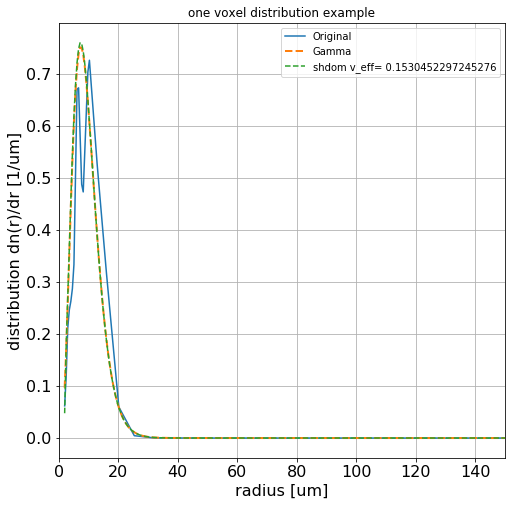

In [31]:
# from plt.plot(rd) - you can see that the bins are not linear
diameters = 2*np.squeeze(rd) # (microns)
min_diff = np.diff(np.squeeze(rd)).min()
interp_bins = int(np.ceil((rd.max() - rd.min())/min_diff))
r = np.linspace(rd.min(), rd.max(), interp_bins)

indxs = np.argwhere(CldMtrx > 0)# cloudy voxel indexes
# here, take for example one voxel with fitted parameters
example_vox_indx = indxs[14166]
# maximum radius is here 14166
# minimum radius is here 4008

DOPC = BinMPhdata[example_vox_indx[0],example_vox_indx[1],example_vox_indx[2],:] # distribution of droplets consintration 
NC = N[example_vox_indx[0],example_vox_indx[1],example_vox_indx[2]] # number concentration of droplets
DOPC_interpulated = interp1d(np.squeeze(rd),DOPC)(r)
ALPHA = alfa[example_vox_indx[0],example_vox_indx[1],example_vox_indx[2]]
b = B[example_vox_indx[0],example_vox_indx[1],example_vox_indx[2]]
c = C[example_vox_indx[0],example_vox_indx[1],example_vox_indx[2]]
reff = RE[example_vox_indx[0],example_vox_indx[1],example_vox_indx[2]]
veff = 1/(ALPHA+3)# accorging to shdom documentation.
print("Eshkols alpha = {}, reff = {}, veff = {}".format(ALPHA,reff,veff))

# maybe I need to convert NC units, currently it is cm^-1
test_gamma = gamma_distribution(r,NC,reff,veff)  
F = fails[example_vox_indx[0],example_vox_indx[1],example_vox_indx[2]]

#---------------------------------------------
re_test = np.trapz(test_gamma*r**3,r, axis=0)/np.trapz(test_gamma*r**2,r, axis=0)
ve_test = np.trapz(((r-reff)**2)*(r**2)*test_gamma,r, axis=0)/(reff**2*np.trapz(test_gamma*r**2,r, axis=0))
print("my gamma reff = {}".format(re_test))
print("my gamma veff = {}".format(ve_test))
"""
parameters for the gamma pdf: the domain average in a vector (alpha,B,C), a matrix of the 3D distribution of each 
gamma parameter separately, a binary cloud matrix that points out where there are cloud (CldMtrx) and a binary matrix 
that has 1 values where I couldn't fit a gamma distribution (fails).
Where alpha=alpha, B=b and C=a*GAMMA(alpha+1)/b^(alpha+1) which is the droplets number concentration.
--------------------------------shdom documentation----------------------------------------------
The gamma distribution of cloud droplet sizes is n(r) = a r^alpha exp(-b*r) where r is the droplet radius, and a, b, 
alpha specify the gamma distribution. The number concentration of droplets is N = a Gamma(alpha+1)/ b^(alpha+1), 
where Gamma is the gamma function. The effective radius of the distribution is r_eff = (alpha+3)/b, while the 
effective variance is v_eff = 1/(alpha+3). A typical value for water clouds is v_eff=0.1 or alpha=7. For ice clouds a 
typical value is alpha=1 or 2. An exponential distribution is obtained with alpha=0. 
A large value of alpha gives close to a monodisperse distribution.
"""

    
f, ax = plt.subplots(1, 1, figsize=(8, 8))
plt.plot(r,DOPC_interpulated,label='Original')
plt.xlim([0 ,150])
plt.xlabel('radius [um]', fontsize=16)
plt.ylabel('distribution dn(r)/dr [1/um]', fontsize=16)
plt.title('one voxel distribution example')

# gamma distribution test:
plt.plot(r,test_gamma,linewidth=2.0,label='Gamma',linestyle = '--')
LWC = 0.0
for ri,n in zip(r,test_gamma):
    LWC = LWC + (1.0E-6*1*n*(4*math.pi/3)*ri**3)
    
# gamma distribution of pyshdom:
mie_mono = shdom.MieMonodisperse(particle_type='Water')
mie_mono.set_wavelength_integration(wavelength_band=(wavelengths[0], wavelengths[0]))   
mie_mono.set_radius_integration(minimum_effective_radius=rd.min(), max_integration_radius=250)
# mie_mono.compute_table()

size_distribution = shdom.SizeDistribution(type='gamma')
# size_distribution.set_parameters(reff=np.array([reff,reff+0.01]), veff=np.array([veff,veff+0.0001]))
size_distribution.set_parameters(reff=np.linspace(1, 81.0, 80), veff=np.linspace(0.01, 0.5, 50))
size_distribution.compute_nd(radii=r, particle_density=mie_mono.pardens)
#
size_dist = size_distribution.get_nd(reff=reff, veff=veff)

#---------------------------------------------
re_test = np.trapz(size_dist*r**3,r, axis=0)/np.trapz(size_dist*r**2,r, axis=0)
print("shdom reff = {}".format(re_test))

plt.plot(r,LWC*size_dist,label='shdom v_eff= {}'.format(veff),linestyle = '--')
# CO = np.nanmean(test_gamma[test_gamma>0][:100]/size_dist[size_dist>0][:100])
# plt.plot(r[test_gamma>0][:100],test_gamma[test_gamma>0][:100]/size_dist[size_dist>0][:100],label='ratio',linestyle = '--')
# ------------------------------------------------------------------------------------------------------------

# sanity check on the consintration
# NC_test = np.trapz(DOPC_interpulated,r, axis=0)
NC_test = np.trapz(DOPC,np.squeeze(rd), axis=0)
print("Eshkols N = {}, tested (sanity check) N = {}".format(NC,NC_test))

ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
plt.grid(True)
plt.legend()

# LOAD DATA FROM ESHKOL APRIL 2020

In [ ]:
dx,dy,dz=(1e-3*50,1e-3*50,1e-3*40) # in km
nz = 100
z_min = 0
z_max = 1e-3*40*nz
zgrid = np.linspace(z_min, z_max-dz ,nz)
# the above parameters should be known in advence.

"""
Eshkol said:
The matrices named fncd are 4D: 128x128x100x33, where horizontal resolution is 50 m and vertical is 40 m. 
The 33 are the size distribution bins according to the same rd.mat vector that I gave you in all previous files.
Number concentration = sum( fncd ) on the forth dimension 
effective radius - re(i,j,k) = sum( rd^3*fncd(i,j,k) )/ sum( rd^2*fncd(i,j,k) )

So from the nc files (each contains x,y,z,time,rn,rd,p,rho,FNCD) I need to extract:
'FNCD': <class 'netCDF4._netCDF4.Variable'>
'rd': <class 'netCDF4._netCDF4.Variable'>

Each nc file has:
variable units shape
x m (128,)
y m (128,)
z m (100,)
time d (1,)
rn micron (33,)
rd micron (33,)
p mb (100,)
rho g/m3 (100,)
FNCD #/cm3/bin  (1, 33, 100, 128, 128)

To work with nc files you need netcdf4 packeg. 
So in the terminal do:
conda install -c anaconda netcdf4
then use: from netCDF4 import Dataset
"""

import re
from tqdm import tqdm
from netCDF4 import Dataset

data_dir = '../WIZ_Clouds/April2020/'
format_ = 'BOMEX_128x128x100_2000CCN_50m_micro_128_*.com3D_int_2.nc'# lod one was .com3D_int_2.nc
volumes_paths = sorted(glob.glob(data_dir + '/'+format_))
volume_stamps = [re.findall('_(\d*).com3D_int_2.nc', i)[0] for i in volumes_paths]
volume_stamps = [int(i) for i in volume_stamps]# convert to integer 

SHOWVOL = True # if true, show evrey volume
IF_SAVE_txt = True
c=0
# for file in [volumes_paths[0]]:
for file in volumes_paths:
    nc = Dataset(file)
    rd = nc.variables['rd'][:].data # units micron
    FNCD = np.squeeze(nc.variables['FNCD'][:].data) # units #/cm3/bin
    # note that the shape of FNCD is now (33, 100, 128, 128)
    
    # LWC:
    # what Eshkol explained with old data: rho - density kg/m^3  - you can use this to convert mixing ratio (LWC [g/kg]]) to liquid water density [g/m^-3]]
    
    #current data:
    # rho - density g/m3:
    rho = nc.variables['rho'][:].data
    
    # loaded evrything I need, now calculate reff, veff, LWC 3d mat:
    min_diff = np.diff(np.squeeze(rd)).min()
    interp_bins = int(np.ceil((rd.max() - rd.min())/min_diff))
    r = np.linspace(rd.min(), rd.max(), interp_bins)
    
    S = np.sum(FNCD, axis=0)
    indxs = np.argwhere(S > 0)# cloudy voxel indexes
    
    # define all:
    SHAPE_3D = FNCD.shape[1:]
    RE = np.zeros(SHAPE_3D)
    VE = np.zeros(SHAPE_3D)
    LWC = np.zeros(SHAPE_3D)
    T = np.zeros(SHAPE_3D)
    # loop over all cloudy voxels
#     for vox_indx in tqdm(indxs):
    for vox_indx in indxs:
        DOPC = FNCD[:,vox_indx[0],vox_indx[1],vox_indx[2]] # distribution of droplets consintration 
        DOPC_interpulated = interp1d(np.squeeze(rd),DOPC)(r)
        #---------------------------------------------
        # calculate reff, veff, LWC from the FNCD (here it doesn't assume gamma distribution):
        reff = np.trapz(DOPC_interpulated*r**3,r, axis=0)/np.trapz(DOPC_interpulated*r**2,r, axis=0)
        RE[vox_indx[0],vox_indx[1],vox_indx[2]] = reff
        VE[vox_indx[0],vox_indx[1],vox_indx[2]] = np.trapz(((r-reff)**2)*(r**2)*DOPC_interpulated,r, axis=0)/(reff**2*np.trapz(DOPC_interpulated*r**2,r, axis=0))

        LWC[vox_indx[0],vox_indx[1],vox_indx[2]] = (10e-3)*(4/3)*np.pi*rho[vox_indx[0]]*np.trapz((r**3)*DOPC_interpulated,r, axis=0)
        # units of rho are g/m^3, of DOPC are #/cm3/um, of r um. The units of the result LWC are [g/m^3]
#         c = c + 1
        T[vox_indx[0],vox_indx[1],vox_indx[2]] = S[vox_indx[0],vox_indx[1],vox_indx[2]]
#         if(c>10000):
#             break;

    
    # here the 3d shape is (100, 128, 128)
    RE = np.transpose(RE, (2, 1, 0))
    VE = np.transpose(RE, (2, 1, 0))
    LWC = np.transpose(RE, (2, 1, 0))
    # here the 3d shape is (128, 128,100)
    
    if(IF_SAVE_txt):
        comment_line = "Data from Eshkol Itan"
        original_name = os.path.basename(file)
        file_name = original_name.split('.')[0]+'.txt'
        print('saving {}'.format(file_name))

        np.savetxt(file_name, X=np.array([RE.shape]), fmt='%d', header=comment_line)
        f = open(file_name, 'ab') 
        
        
        np.savetxt(f, X=np.concatenate((np.array([dx, dy]), zgrid)).reshape(1,-1), fmt='%2.3f')
        nx, ny, nz = RE.shape
        lwc = LWC
        reff = RE
        veff = VE
        y, x, z = np.meshgrid(range(ny), range(nx), range(nz))
        data = np.vstack((x.ravel(), y.ravel(), z.ravel(), lwc.ravel(), reff.ravel(), veff.ravel())).T
        np.savetxt(f, X=data, fmt='%d %d %d %.5f %.3f')        
        f.close()  
        
    if(SHOWVOL):
        res3d = (0.05,0.05,0.04) # horizontal resolution is 50 m and vertical is 40 m
        viz3D(RE, res3d = res3d,title='re [um]')
            
            
# in pyshdom liquid water content lwc is of units (g/m^3).




  1%|          | 4017/448714 [00:25<11:08, 665.34it/s]

# Work on one voxel to test the units and some operations


(10.0, 80.0, 12.7, array([2.475, 3.175, 2.54 ]))


calculated LWC = 0.004066051815075503 [g/m^3]
calculated reff = 203.43140810753337 [um]
calculated veff = 0.0888268247736258
gamma reff = 203.43140810753334
shdom reff = 203.4268204562324


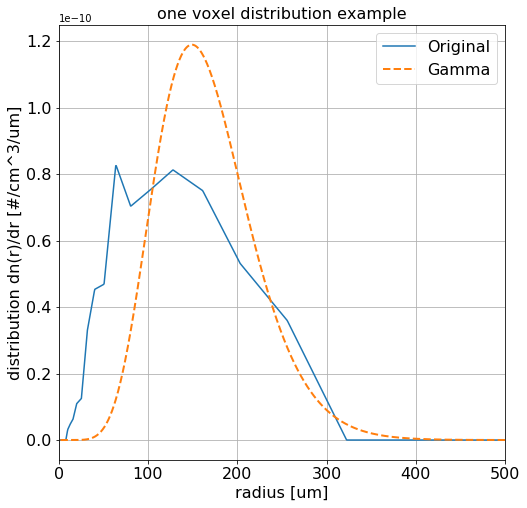

In [125]:
nc = Dataset(volumes_paths[0])
rd = nc.variables['rd'][:].data # units micron
FNCD = np.squeeze(nc.variables['FNCD'][:].data) # units #/cm3/bin
# note that the shape of FNCD is now (33, 100, 128, 128)

# LWC:
# what Eshkol explained with old data: rho - density kg/m^3  - you can use this to convert mixing ratio (LWC [g/kg]]) to liquid water density [g/m^-3]]

#current data:
# rho - density g/m3:
rho = nc.variables['rho'][:].data

# from plt.plot(rd) - you can see that the bins are not linear
min_diff = np.diff(np.squeeze(rd)).min()
interp_bins = int(np.ceil((rd.max() - rd.min())/min_diff))
r = np.linspace(rd.min(), rd.max(), interp_bins)

# here, take for example one voxel:
S = np.sum(FNCD, axis=0)
indxs = np.argwhere(S > 0)# cloudy voxel indexes
example_vox_indx = indxs[1166]
# maximum radius is here ?
# minimum radius is here ?

DOPC = FNCD[:,example_vox_indx[0],example_vox_indx[1],example_vox_indx[2]] # distribution of droplets consintration 
DOPC_interpulated = interp1d(np.squeeze(rd),DOPC)(r)
#---------------------------------------------
# calculate reff, veff, LWC from the FNCD (here it doesn't assume gamma distribution):
reff = np.trapz(DOPC_interpulated*r**3,r, axis=0)/np.trapz(DOPC_interpulated*r**2,r, axis=0)
veff = np.trapz(((r-reff)**2)*(r**2)*DOPC_interpulated,r, axis=0)/(reff**2*np.trapz(DOPC_interpulated*r**2,r, axis=0))

LWC = (10e-3)*(4/3)*np.pi*rho[example_vox_indx[0]]*np.trapz((r**3)*DOPC_interpulated,r, axis=0)
# units of rho are g/m^3, of DOPC are #/cm3/um, of r um. The units of the result LWC are [g/m^3]
print("calculated LWC = {} [g/m^3]".format(LWC))
print("calculated reff = {} [um]".format(reff))
print("calculated veff = {}".format(veff))

# try to fit gamma distribution:
NC = np.trapz(DOPC,np.squeeze(rd), axis=0)# total consintration
test_gamma = gamma_distribution(r,NC,reff,veff)  

#---------------------------------------------
re_test = np.trapz(test_gamma*r**3,r, axis=0)/np.trapz(test_gamma*r**2,r, axis=0)
print("gamma reff = {}".format(re_test))

# plot
f, ax = plt.subplots(1, 1, figsize=(8, 8))
plt.plot(r,DOPC_interpulated,label='Original')
plt.xlim([0 ,500])
plt.xlabel('radius [um]', fontsize=16)
plt.ylabel('distribution dn(r)/dr [#/cm^3/um]', fontsize=16)
plt.title('one voxel distribution example', fontsize=16)

# gamma distribution test:
plt.plot(r,test_gamma,linewidth=2.0,label='Gamma',linestyle = '--')
LWC = 0.0
for ri,n in zip(r,test_gamma):
    LWC = LWC + (1.0E-6*1*n*(4*math.pi/3)*ri**3)
    
# gamma distribution of pyshdom:
mie_mono = shdom.MieMonodisperse(particle_type='Water')
mie_mono.set_wavelength_integration(wavelength_band=(wavelengths[0], wavelengths[0]))   
mie_mono.set_radius_integration(minimum_effective_radius=rd.min(), max_integration_radius=250)

size_distribution = shdom.SizeDistribution(type='gamma')
size_distribution.set_parameters(reff=np.linspace(1, 1.5*reff, 100), veff=np.linspace(0.01, 0.5, 50))
size_distribution.compute_nd(radii=r, particle_density=mie_mono.pardens)
#
size_dist = size_distribution.get_nd(reff=reff, veff=veff)

#---------------------------------------------
re_test = np.trapz(size_dist*r**3,r, axis=0)/np.trapz(size_dist*r**2,r, axis=0)
print("shdom reff = {}".format(re_test))

# plt.plot(r,LWC*size_dist,label='shdom v_eff= {}'.format(veff),linestyle = '--')

ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
plt.grid(True)
plt.legend(prop={'size': 16})

In [146]:

    
res3d = (0.05,0.05,0.04)
viz3D(S, res3d = res3d,title='re [um]')

(10.0, 80.0, 12.7, array([2.475, 3.175, 2.54 ]))


# ?

Text(0.5, 1.0, 'rho(z)')

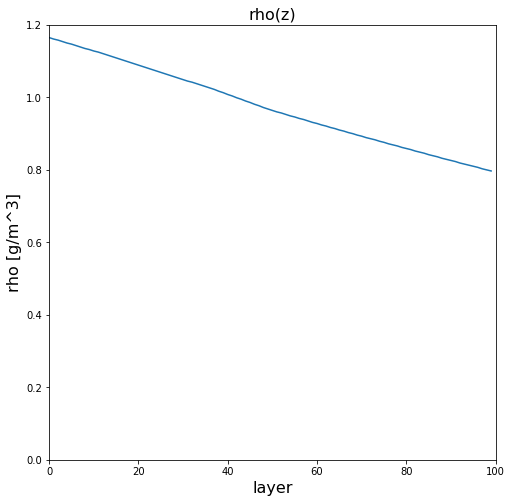

In [118]:

f, ax = plt.subplots(1, 1, figsize=(8, 8))
plt.plot(np.arange(100),rho,label='rho')
plt.xlim([0 ,100])
plt.ylim([0 ,1.2])
plt.xlabel('layer', fontsize=16)
plt.ylabel('rho [g/m^3]', fontsize=16)
plt.title('rho(z)', fontsize=16)

'BOMEX_128x128x100_2000CCN_50m_micro_128_0000007200'

In [139]:
SHAPE_3D

(100, 128, 128)

In [135]:
np.transpose(RE, (2, 1, 0)).shape

(128, 128, 100)